In [2]:
!pip install --upgrade git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-26zw35pd
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-26zw35pd
  Resolved https://github.com/huggingface/transformers to commit de55ead1f1acb218edf7994a4034fc6f77d636e2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 18.7 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.35.0.dev0-py3-none-any.whl size=7792968 sha256=080e1b595678135f7fdf096e69004b1d670bdb72c354335e537a6852a4e0e06e
  Stored in directory: /tmp/pip-ephem-wheel-cache-y7p3

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import OneHotEncoder
import pickle
import os
import random

from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

import sklearn
print(sklearn.__version__) # should be 1.0.2

1.0.2


In [3]:
# Load Instadeep's model
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-100m-multi-species", trust_remote_code=True)
model = AutoModelForMaskedLM.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-100m-multi-species", trust_remote_code=True)

In [4]:
max_length = 5800 // 6
print(max_length)

966


In [5]:
AA_MAPPING = {
  'A': ['GCT', 'GCC', 'GCA', 'GCG'],
  'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
  'N': ['AAT', 'AAC'],
  'D': ['GAT', 'GAC'],
  'C': ['TGT', 'TGC'],
  'Q': ['CAA', 'CAG'],
  'E': ['GAA', 'GAG'],
  'G': ['GGT', 'GGC', 'GGA', 'GGG'],
  'H': ['CAT', 'CAC'],
  'I': ['ATT', 'ATC', 'ATA'],
  'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
  'K': ['AAA', 'AAG'],
  'M': ['ATG'],
  'F': ['TTT', 'TTC'],
  'P': ['CCT', 'CCC', 'CCA', 'CCG'],
  'O': ['TAG'],
  'U': ['TGA'],
  'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
  'T': ['ACT', 'ACC', 'ACA', 'ACG'],
  'W': ['TGG'],
  'Y': ['TAT', 'TAC'],
  'V': ['GTT', 'GTC', 'GTA', 'GTG'],
}

def most_frequent_codons(protein: str) -> str:
    # source: https://www.genscript.com/tools/codon-frequency-table
    # Manually took the highest frequency codon for each AA
    CANONICAL_CODON = {
        'F': 'TTT',
        'Y': 'TAT',
        'L': 'CTG',
        'H': 'CAT',
        'Q': 'CAG',
        'I': 'ATT',
        'M': 'ATG',
        'N': 'AAC',
        'K': 'AAA',
        'V': 'GTG',
        'D': 'GAT',
        'E': 'GAA',
        'S': 'AGC',
        'C': 'TGC',
        'P': 'CCG',
        'R': 'CGT',
        'T': 'ACC',
        'A': 'GCG',
        'G': 'GGC',
        'W': 'TGG',
    }
    return "".join(CANONICAL_CODON[x] for x in protein)

def switch_codon(protein: str) -> str:
    basis = most_frequent_codons(protein)
    position = random.choice(range(len(protein)))
    res = basis[:(position)*3] + random.choice(AA_MAPPING[protein[position]]) + basis[(position+1)*3:]
    return ''.join(res)

def generate_plasmids(protein: str, k: int):
    res = set([most_frequent_codons(protein)])
    while True:
        candidate = switch_codon(protein)
        res.add(candidate)
        if len(res) >= k:
            break
    return res

In [6]:
def get_tokens(sequences, tokenizer):
    token_ids = tokenizer.batch_encode_plus(sequences,
                                            return_tensors='pt',
                                            padding='max_length',
                                            max_length=max_length)['input_ids']
    return token_ids

def get_embeddings(tokens, model, batch_size=4):
    res = []
    for i in tqdm(range(0, tokens.shape[0], batch_size)):
        batch = tokens[i:min(i+batch_size, tokens.shape[0])]
        attention_mask = batch != tokenizer.pad_token_id
        embeddings = model(
            batch,
            attention_mask=attention_mask,
            encoder_attention_mask=attention_mask,
            output_hidden_states=True
        )['hidden_states'][-1].detach().cpu().numpy()
        res.append(embeddings)
    return np.concatenate(res)

def pool(embeddings, lengths):
    pooled = np.zeros((embeddings.shape[0], embeddings.shape[2]))
    for i in range(embeddings.shape[0]):
        pooled[i] = np.mean(embeddings[i, :lengths[i], :], axis=0)
    return pooled

# Species one hot encoder
with open('species_encoder.pkl', 'rb') as pkl:
    enc = pickle.load(pkl)

def add_species(X, species, enc):
    X_spec = enc.transform(species).toarray()
    return np.concatenate([X, X_spec], axis=1)

In [7]:
with open('protein_design/mutants.txt', 'r') as f:
    mutants = [s.strip() for s in f.readlines()]

In [8]:
with open('lasso_30000.pkl', 'rb') as f:
    clf = pickle.load(f)

In [9]:
device = torch.device('cuda')
model = model.to(device)

In [17]:
best_scores = []
best_plasmids = []
for i in range(len(mutants)):
    plasmids = list(generate_plasmids(mutants[i], 16))
    lengths = [len(s) for s in plasmids]
    tokens = get_tokens(plasmids, tokenizer)
    tokens = tokens.to(device)
    embeddings = get_embeddings(tokens, model)
    X = pool(embeddings, lengths)
    species = np.array(['human'] * len(plasmids)).reshape((-1, 1))
    X = add_species(X, species, enc)
    preds = clf.predict(X)
    top = np.argmax(preds)
    best_scores.append(preds[top])
    best_plasmids.append(plasmids[top])

100%|██████████| 4/4 [00:01<00:00,  2.15it/s]


In [16]:
with open('protein_design/parent_antibody.txt', 'r') as f:
    parent = f.read().strip()
plasmids = list(generate_plasmids(parent, 32))
lengths = [len(s) for s in plasmids]
tokens = get_tokens(plasmids, tokenizer)
tokens = tokens.to(device)
embeddings = get_embeddings(tokens, model)
X = pool(embeddings, lengths)
species = np.array(['human'] * len(plasmids)).reshape((-1, 1))
X = add_species(X, species, enc)
parent_preds = clf.predict(X)

100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

[]

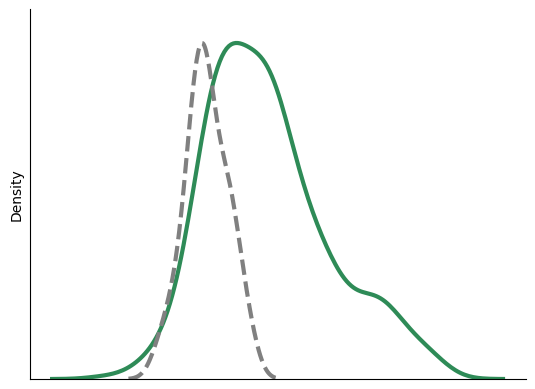

In [27]:
fig, ax = plt.subplots()

sns.kdeplot(best_scores, ax=ax, c='seagreen', lw=3)
sns.kdeplot(parent_preds, ax=ax, c='gray', ls='--', lw=3)

for i in (0, 1):
  ax.lines[i].set_ydata(ax.lines[i].get_ydata() / max(ax.lines[i].get_ydata()))
ax.set_ylim(0, 1.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])